# Pipeline : 
### data processing of the manually annoted dataset
### image processing : extraction of RGB volumes
### classifier based on WND-charm Model
### PCA & RDF
### Build a classifier
### Analyse False Positives
### Prediction of Neurons, Astrocytes, Background in ROI's clone

In [1]:
import numpy as np
import pandas as pd
from functools import partial
import multiprocessing
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as cm
import pickle
from pandas import DataFrame, read_csv,concat,merge

In [2]:
%run ./configure.ipynb

In [3]:
%run ../Connection_to_server.ipynb

In [4]:
imageId = 451
weight=25
height=25

## Pre-pocessing of the manually annotated Dataset

In [5]:
import Pre_Processing_the_annotated_dataset as pp
reload(pp);

In [6]:
dfpoints=read_csv(projectpath+'io/Input/Bloc01_pointes_first_mod.csv')

In [7]:
dfpoints=pp.Get_Dataframe(imageId, dfpoints)

## Reduce the number of Neurons in order to have as many as Astrocytes

In [8]:
import Reduction_of_Neurons_in_the_DataFrame as nr
reload(nr);

In [9]:
dfpoints=nr.Get_DataFrame_less_Neurons(dfpoints)

In [10]:
DF_=nr.Get_Data_frame(imageId, dfpoints)

In [11]:
import Fonctions_used_for_many_DF_pre_processing as fct_pp
reload(fct_pp);

In [12]:
Data_FRAMES=fct_pp.getDF(DF_)

In [13]:
Data_FRAMES=fct_pp.Switch_Indices(Data_FRAMES)

In [14]:
Data_FRAMES=fct_pp.exclure(Data_FRAMES,weight, height)

In [15]:
D_F=fct_pp.getDF(Data_FRAMES)

In [16]:
Data_FRAMES=fct_pp.Switch_Indices(D_F)

In [17]:
Data_FRAMES.to_pickle(projectpath+'io/Output/Data_FRAMES.pkl')

# Add a fourth class to the data Frame (Background Type :4)

In [18]:
Data_FRAMES=pd.read_pickle(projectpath+'io/Output/Data_FRAMES.pkl')

In [19]:
import Add_Background_class_to_Dataframe as Bc
reload(Bc);

In [20]:
New_DF=Bc.Get_Df_with_backgroung_class(Data_FRAMES,imageId)

In [21]:
New_DF=fct_pp.exclure_Bc(New_DF,weight,height)

In [22]:
New_DF=fct_pp.getDF(New_DF)

In [23]:
New_DF=fct_pp.Switch_Indices(New_DF)

# Create the full data Frame ( 526 Adtrocytes, 528 Neurons, 540 background) 

In [24]:
# Join the 2 DataFrames
Dataframe_=pd.concat([Data_FRAMES, New_DF], axis=0)

In [25]:
Dataframe_=fct_pp.getDF(Dataframe_)

In [26]:
Dataframe_=fct_pp.Switch_Indices(Dataframe_)

In [27]:
Dataframe_.to_pickle(projectpath+'io/Output/Dataframe_.pkl')

In [28]:
Data_FRAMES=pd.read_pickle(projectpath+'io/Output/Dataframe_.pkl')

# Get volumes with Multiprocessing

In [29]:
import Get_Partial_Data as gpd
reload(gpd);

In [32]:
#Metrics
zsize=3
nidx=Data_FRAMES.shape[0] 

In [33]:
partial_getDATA_MEAN = partial(gpd.get_mean_zstacks_data, imageId=imageId, zsize=zsize, h=height, w=weight, Data_F=Data_FRAMES)

In [34]:
filename_M_DF =projectpath+'io/Output/M_DF.npy'

## Load Normalized volums as numpy array

In [35]:
M_DF_parallel=np.load(filename_M_DF)

# Display the RGB images corresponding to normalized volums

In [36]:
import Display_RGB_Vol as rgb_im
reload(rgb_im);

# 4- WND CHARM Method

## 4.1- Convert RGB images to Grayscale

In [38]:
import RGB2GRAY
reload(RGB2GRAY);

In [39]:
partial_get_Gray_Img = partial(RGB2GRAY.Convert_Im_in_Gray_levels, h=height, w=weight, M_mean=M_DF_parallel)

In [40]:
filename_Gray_IM =projectpath+'io/Output/GRAY_IM.npy'

## Load the gray images as numpy array

In [41]:
filename_Gray_IM =projectpath+'io/Output/GRAY_IM.npy'

In [42]:
GRAY_IM_parallel=np.load(filename_Gray_IM)

# Display images by class ( 1 or 2) in order to detect the false predictions

In [43]:
import Display_img_false_prediction as imf
reload(imf);

In [44]:
(Astrocytes, Neurons, Background)=imf.separate_in_3_classes(Data_FRAMES)

## 4.2- Extraction of the WND-CHARM Features

In [45]:
nb_features=2919

In [46]:
import Features_computing as FC
reload(FC);

In [47]:
partial_get_FEATURES = partial(FC.Features_calcul_np_GrayscaleIm_WND, nb_features=nb_features, w=weight, h=height, GRAY=GRAY_IM_parallel)

In [48]:
filename_FEATURES =projectpath+'io/Output/FEATURES.npy'

## Load the extracted Features

In [49]:
FEATURES=np.load(filename_FEATURES)

## Etablish one np.array for the Features' Names & another one for Features' Values

In [50]:
FEAT_NAMES=FEATURES[:,1,:]

In [51]:
FEAT_VALUES=FEATURES[:,0,:]

In [52]:
FEAT_VALUES=FEAT_VALUES.astype(float)

In [53]:
filename_FEATURES_Val =projectpath+'io/Output/FEATURES_Val.npy'

In [54]:
np.save(filename_FEATURES_Val,FEAT_VALUES)

In [55]:
FEAT_VALUES=np.load(filename_FEATURES_Val)

# 4.3- Features Post- processing

## A- Get the normalized Features

In [56]:
partial_get_NORMALIZED_FEAT = partial(FC.Get_Normalized_FEATURES, FV=FEAT_VALUES)

In [57]:
filename_FVN =projectpath+'io/Output/FV_N.npy'

In [58]:
FV_N=np.load(filename_FVN)

# PCA & Random Forest Classification

In [ ]:
%%time
%run ./Pipeline_PCA_RANDOM_Forest_Copy1.ipynb
# CPU times: user 16min 53s, sys: 1h 52s, total: 1h 17min 45s
# Wall time: 6min 58s

# Imshow specific images to understand non differentiation in PCA model

# process in order to display false predicted images

In [ ]:
(fail_img_pred_Neurons,fail_img_pred_Astrocytes,fail_img_pred_Background)=imf.Get_IMG_failed_prediction(yr,predictedVAL)

In [ ]:
sns.reset_orig() # sns.set()

# test prediction sur  1 clone

# FAIRE DES MODIFS !

In [59]:
import Get_coordinates as gC
reload(gC);

In [60]:
conn = BlitzGateway('tbacoyannis','d33pl34rn1ng',port=4064,host='chinensis.polytechnique.fr')
connected = conn.connect()

image = conn.getObject("Image", imageId)
pixels = image.getPrimaryPixels() # get raw pixels information

size_x=image.getSizeX()
size_y=image.getSizeY()
size_z = image.getSizeZ()
size_c = image.getSizeC()
size_t = image.getSizeT()

large= weight  
nidY=size_x/(int(large/int(large/2)))-3

In [62]:
partial_getDATA_coord = partial(gC.get_coordinates, imageId=imageId, large=large)

In [63]:
filename_res =projectpath+'io/Output/res.npy'

In [64]:
res=np.load(filename_res)

In [65]:
M_Mv=res[:,0]
liste_coordonnees=res[:,1]

In [66]:
# Coordinates of the ROI in the original image
x_min=48+367
y_min=2064+646
w=615-367
h=920-646
x_max=x_min+w
y_max=y_min+h

In [67]:
# Reshape the list of coordinates
b=np.vstack(liste_coordonnees)

In [68]:
x_from_liste_coordonnees=b[:,0]
y_from_liste_coordonnees=b[:,1]
ind_lign_from_liste_coordonnees=b[:,2]
ind_col_from_liste_coordonnees=b[:,3]

In [69]:
filename_Matrix_TEST =projectpath+'io/Output/Matrix_TEST.npy'

In [70]:
Matrix_TEST=np.load(filename_Matrix_TEST)

In [71]:
coords=np.where((np.hstack(x_from_liste_coordonnees)>=x_min) & (np.hstack(x_from_liste_coordonnees)<=x_max) & (np.hstack(y_from_liste_coordonnees)>=y_min) & (np.hstack(y_from_liste_coordonnees)<=y_max))[0]

In [72]:
filename_Im_to_convert_GRAY =projectpath+'io/Output/Im_to_convert_GRAY.npy'

In [73]:
Im_to_convert_GRAY=Matrix_TEST[coords]

In [74]:
np.save(filename_Im_to_convert_GRAY ,Im_to_convert_GRAY)

## Process for one tile ipynb

In [77]:
import process_for_one_tile as pt
reload(pt);

/home/tbacoyannis/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tbacoyannis/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [78]:
Im_to_convert_GRAY=np.load(filename_Im_to_convert_GRAY)

In [79]:
size_=Im_to_convert_GRAY.shape[0]-1
nidx=Im_to_convert_GRAY.shape[0]

In [80]:
partial_get_Get_proba = partial(pt.Get_proba, h=height, w=weight, M_mean=Im_to_convert_GRAY, nb_features=nb_features)

In [81]:
filename_Im_Proba =projectpath+'io/Output/Im_Proba.npy'

In [ ]:
################################"

In [82]:
Im_Proba=np.load(filename_Im_Proba)

In [83]:
Im_proba=np.zeros([Im_Proba.shape[0], Im_Proba.shape[2]])

for g in range(0,Im_Proba.shape[0]):
    Im_proba[g]=Im_Proba[g][g]

In [84]:
filename_Im_proba =projectpath+'io/Output/Im_proba.npy'

In [85]:
Im_proba=np.save(filename_Im_proba,Im_proba)

In [86]:
Im_proba=np.load(filename_Im_proba)

In [87]:
Probability_img=np.zeros([Im_proba.shape[0]+1,Im_proba.shape[1]])
Probability_img[:Im_proba.shape[0]]=Im_proba
Probability_img[Im_proba.shape[0]]=Probability_img[Im_proba.shape[0]-1]

In [88]:
conn = BlitzGateway('tbacoyannis','d33pl34rn1ng',port=4064,host='chinensis.polytechnique.fr')
connected = conn.connect()
imageId=451
image = conn.getObject("Image", imageId)
pixels = image.getPrimaryPixels() # get raw pixels information

pxobj_CH1 = pixels.getTile(theZ=103, theC=0, theT=0, tile=(x_min,y_min, x_max-x_min , y_max-y_min ))
pxobj_CH2 = pixels.getTile(theZ=103, theC=1, theT=0, tile=(x_min,y_min, x_max-x_min , y_max-y_min ))
pxobj_CH3 = pixels.getTile(theZ=103, theC=2, theT=0, tile=(x_min,y_min, x_max-x_min , y_max-y_min ))

In [102]:
# Get the normalized original image
pxobj=(pxobj_CH1+pxobj_CH2+pxobj_CH3)/3

In [90]:
e=124
CH1=Probability_img[:,0]
CH1=np.reshape(CH1, (-1, e) )
CH1=CH1[:,:, np.newaxis]
#     plt.title('Proba Astrocytes')

CH2=Probability_img[:,1]
CH2=np.reshape(CH2,(-1,e))
CH2=CH2[:,:,np.newaxis]
#     plt.title('Proba Neurons')


CH3=Probability_img[:,2]
CH3=np.reshape(CH3, (-1, e) )
CH3=CH3[:,:,np.newaxis]
#     plt.title('Proba Background')

Z=np.dstack([CH1,CH2,CH3])

In [91]:
filename_RGB_proba_im =projectpath+'io/Output/RGB_proba_im.npy'

In [92]:
np.save(filename_RGB_proba_im,Z)

In [93]:
Z=np.load(filename_RGB_proba_im)

In [100]:
import IM_Display_RGB as imd
reload(imd);

<IPython.core.display.Javascript object>


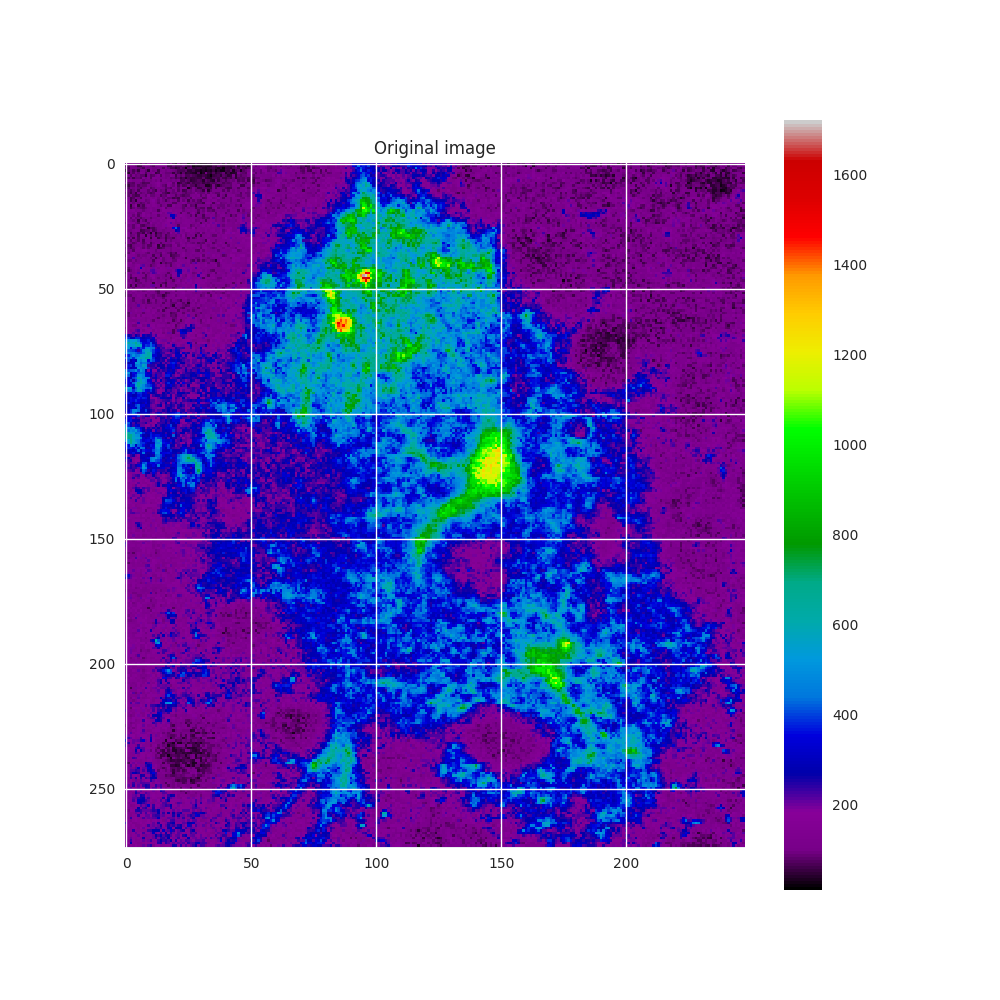

In [101]:
imd.imshowRGB(Z,pxobj,10)